#**Brain Tumor Detection On Magnetic Resonance Images With Deep Neural Network Method**


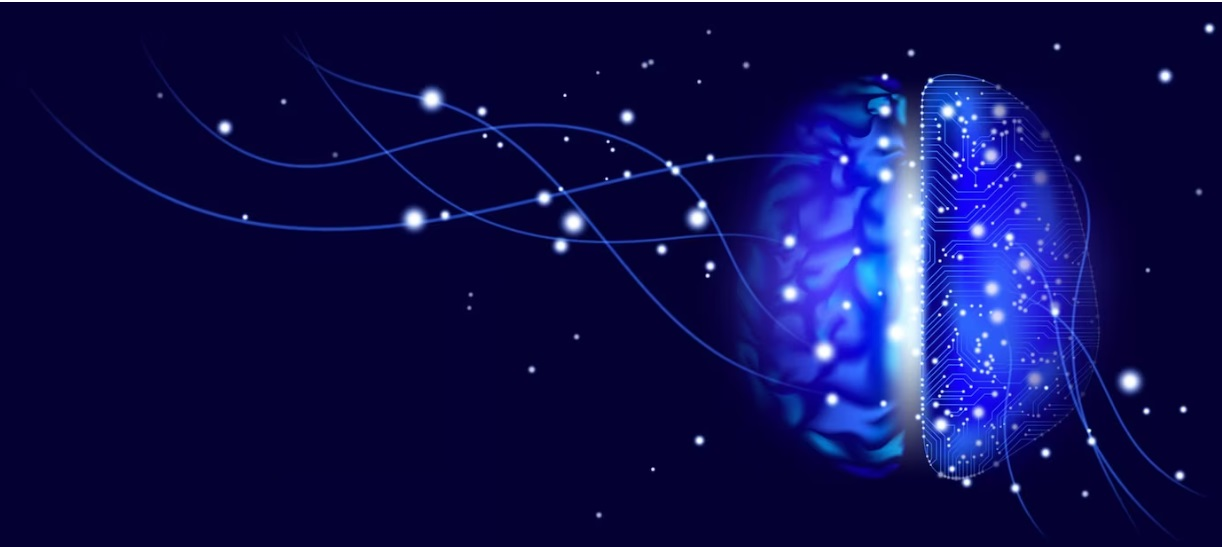

---

* **Author** :
Muh Royan Fauzi Maulana

* **Research Title** : Brain Tumor Detection
On Magnetic Resonance Images With
Deep Neural Network Method

* **Description** :
The brain tumor was detected using a deep learning method that create a model from MRI Brain Images with a labeled dataset. The model has a pattern of a unique label from a weighted neuron that is trained over a dataset.

* **Objectives and Benefits** :
  - Produce a prototype tool that can diagnose brain tumors through patterns on MRI.
  - Analyzing the speed and accuracy of the deep neural network method in recognizing patterns on MRI.
* **Data** :
3000 images consist of 1500 Images Tumor & 1500 of Healthy Brain Images

* **Method** :
Deep Neural Network

* **Metrics** :
  - F1-Score
  - Sensitivity
  - Specificity
  - TPR
  - FPR
  - Accuracy

* **Hardware Acceleration** :
  Running On Local GPU : Nvidia GTX 1650 Max-Q Design 4 GB RAM

##Check GPU

In [ ]:
# Check GPU hardware availability
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##Import Library

In [ ]:
# Visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Dir manipulation library
import os
from shutil import copyfile

# Machine Learning Framework Library
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow as tf
  # Library Optimizer
from tensorflow.keras.optimizers import RMSprop
  # Libary Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Library For Hyperparameter Tuning
import keras_tuner as kt

# Matrix Manipulation
import numpy as np
# import pandas as pd

# Etc
import random
from IPython.display import Image, display
import util



In [ ]:
%load_ext tensorboard

In [ ]:
# ConfiguR More GPU memory allocate to virtual Env
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


##Spliting Dataset

In [ ]:
def split_data(source, target):
    '''Split Dataset From source to dataset with split_size proportion for train-val-test : 70 - 20 - 10'''

    # Check File is Null or No
    for dir in os.listdir(source):
        file_dir_path = os.path.join(source, dir)
        all_files_dir = []
        print(f"adding {dir} to variabel")

        for file in os.listdir(os.path.join(source,dir)):
            file_path = os.path.join(file_dir_path,file)
            if os.path.getsize(file_path):
                all_files_dir.append(file)
                print(f"Adding Non-Zero File {file} to variabel")
            else:
                print('{} is zero length, so ignoring'.format(file))

        # Get Index of list for slicing with in train-val-test proportion
        sum_files = len(all_files_dir)
        split_point = int(sum_files * 0.7)
        split_point_mid = int(sum_files * 0.3)
        split_point_end = int(sum_files * 0.1)

        # Shuffle images for train-val-set within proportion
        shuffled = random.sample(all_files_dir, sum_files)
        train_set = shuffled[:split_point]
        val_set = shuffled[-split_point_mid:-split_point_end]
        test_set = shuffled[-split_point_end:]

        # Get Dir Path
        train_dir = os.path.join(target, os.path.join("train",dir))
        val_dir = os.path.join(target, os.path.join("val",dir))
        test_dir = os.path.join(target, os.path.join("test",dir))

        os.makedirs(train_dir)
        os.makedirs(val_dir)
        os.makedirs(test_dir)

        # Copy file to new dir according proportion
        for file in train_set:
            copyfile(os.path.join(file_dir_path, file), os.path.join(train_dir,file))
            print(f"succes adding {file} to {train_dir}")

        for file in val_set:
            copyfile(os.path.join(file_dir_path, file), os.path.join(val_dir,file))
            print(f"succes adding {file} to {val_dir}")

        for file in test_set:
            copyfile(os.path.join(file_dir_path, file), os.path.join(test_dir,file))
            print(f"Succes adding {file} to {test_dir}")

In [ ]:
source = "D:STORAGE/Muh-Royan-F-M/Sistem Informasi/Skipsi/My Skripsi/Lab/Dataset/source"
destination_dir_split = "D:STORAGE/Muh-Royan-F-M/Sistem Informasi/Skipsi/My Skripsi/Lab/Dataset/train-val-test"

#  Run Function Spliting data
split_data(source, destination_dir_split)

Streaming output truncated to the last 5000 lines.
Adding Non-Zero File no55.jpg to variabel
Adding Non-Zero File no550.jpg to variabel
Adding Non-Zero File no551.jpg to variabel
Adding Non-Zero File no552.jpg to variabel
Adding Non-Zero File no553.jpg to variabel
Adding Non-Zero File no554.jpg to variabel
Adding Non-Zero File no555.jpg to variabel
Adding Non-Zero File no556.jpg to variabel
Adding Non-Zero File no557.jpg to variabel
Adding Non-Zero File no558.jpg to variabel
Adding Non-Zero File no559.jpg to variabel
Adding Non-Zero File no56.jpg to variabel
Adding Non-Zero File no560.jpg to variabel
Adding Non-Zero File no561.jpg to variabel
Adding Non-Zero File no562.jpg to variabel
Adding Non-Zero File no563.jpg to variabel
Adding Non-Zero File no564.jpg to variabel
Adding Non-Zero File no565.jpg to variabel
Adding Non-Zero File no566.jpg to variabel
Adding Non-Zero File no567.jpg to variabel
Adding Non-Zero File no568.jpg to variabel
Adding Non-Zero File no569.jpg to variabel
Addin

## Define Function

In [ ]:
def Custom_Metrics(tp,tn,fp,fn):
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  DSC = (2*tp) / (fp + (2*tp) + fn)
  F1_score =  (2 * precision * recall) / (precision + recall)

  return sensitivity, specificity, precision, recall, DSC, F1_score

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.TruePositives(name = "TP"),
    tf.keras.metrics.TrueNegatives(name = "TN"),
    tf.keras.metrics.FalsePositives(name = "FP"),
    tf.keras.metrics.FalseNegatives(name = "FN"),
    tf.keras.metrics.Precision(name="precision"),
]

## A. Exploratory Data analysis

In [ ]:
base_dir = "D:/STORAGE/Muh-Royan-F-M/Sistem Informasi/Skipsi/My-Skripsi/Lab/Dataset/train-val-test"
#Folder Train, Validation, and Testing
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
testing_dir = os.path.join(base_dir, 'test')

# Directory with training  pictures
train_yes_dir = os.path.join(train_dir, 'yes')
train_no_dir = os.path.join(train_dir, 'no')

# Directory with validation pictures
validation_yes_dir = os.path.join(validation_dir, 'yes')
validation_no_dir = os.path.join(validation_dir, 'no')

# Directory with testing pictures
testing_yes_dir = os.path.join(testing_dir, 'yes')
testing_no_dir = os.path.join(testing_dir, 'no')

In [ ]:
train_yes_fnames = os.listdir( train_yes_dir )
train_no_fnames = os.listdir( train_no_dir )

In [ ]:
#Print Total Images
print('total training tumor images \t\t:', len(os.listdir(train_yes_dir )), "Image")
print('total training healthy images \t\t:', len(os.listdir(train_no_dir )), "Image")
print("\n")
print('total validation tumor images \t\t:', len(os.listdir(validation_yes_dir)), "Image")
print('total validation healthy images \t:', len(os.listdir(validation_no_dir)), "Image")
print("\n")
print('total testing healthy images \t\t:', len(os.listdir(testing_yes_dir)), "Image")
print('total testing miner images \t\t:', len(os.listdir(testing_no_dir)), "Image")

total training tumor images 		: 1050 Image
total training healthy images 		: 1050 Image


total validation tumor images 		: 300 Image
total validation healthy images 	: 300 Image


total testing healthy images 		: 150 Image
total testing miner images 		: 150 Image


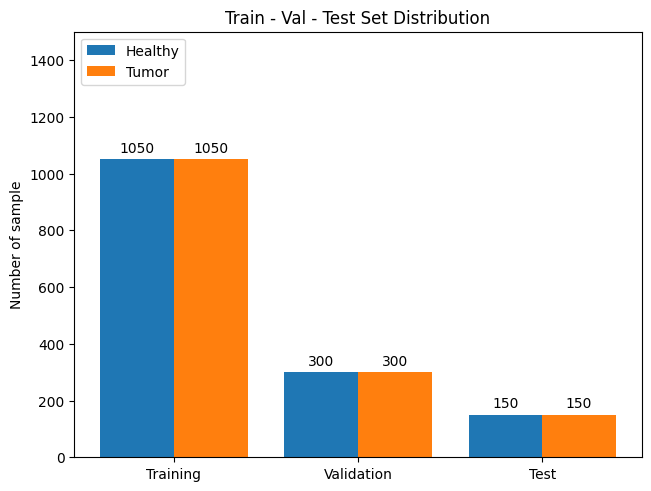

In [ ]:
# data to plot
train_healthy = len(os.listdir(train_no_dir ))
train_tumor = len(os.listdir(train_yes_dir ))

val_healthy = len(os.listdir(validation_no_dir ))
val_tumor = len(os.listdir(validation_yes_dir ))

test_healthy = len(os.listdir(testing_no_dir ))
test_tumor = len(os.listdir(testing_yes_dir ))

split = ("Training", "Validation", "Test")
num_set = {
    'Healthy': (train_healthy, val_healthy, test_healthy),
    'Tumor': (train_tumor, val_tumor, test_tumor),
}

x = np.arange(len(split))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in num_set.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of sample')
ax.set_title('Train - Val - Test Set Distribution')
ax.set_xticks(x + (width/2), split)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1500)

plt.show()

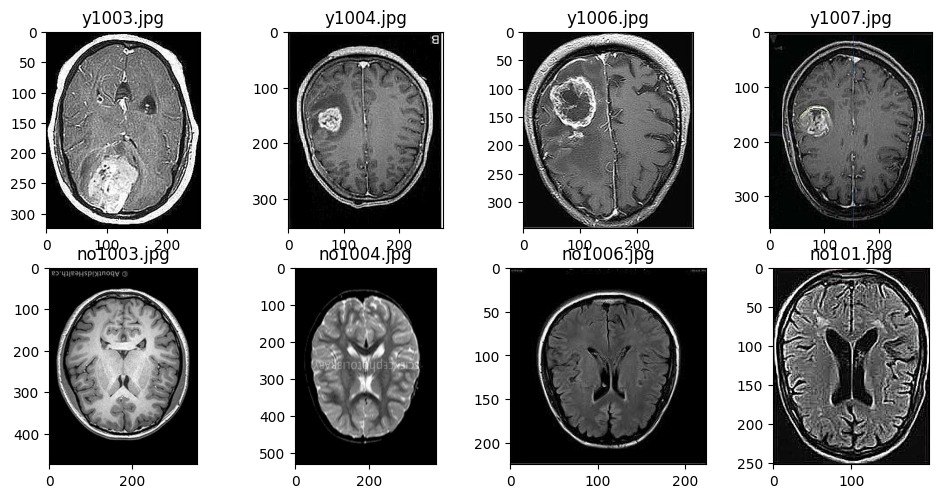

In [ ]:
#Showing Sample Image each Class

%matplotlib inline

# Parameters for our graph; we'll output images in a 4x8 configuration
nrows = 8
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x8 pics
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=10

next_tumor_pix = [os.path.join(train_yes_dir, fname)
                for fname in train_yes_fnames[ pic_index-4:pic_index]
               ]

next_healthy_pix = [os.path.join(train_no_dir, fname)
                for fname in train_no_fnames[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(next_tumor_pix+next_healthy_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  # sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(os.path.basename(img_path))

plt.show()


Pixel Distibution

Text(0.5, 0, 'Pixel Value')

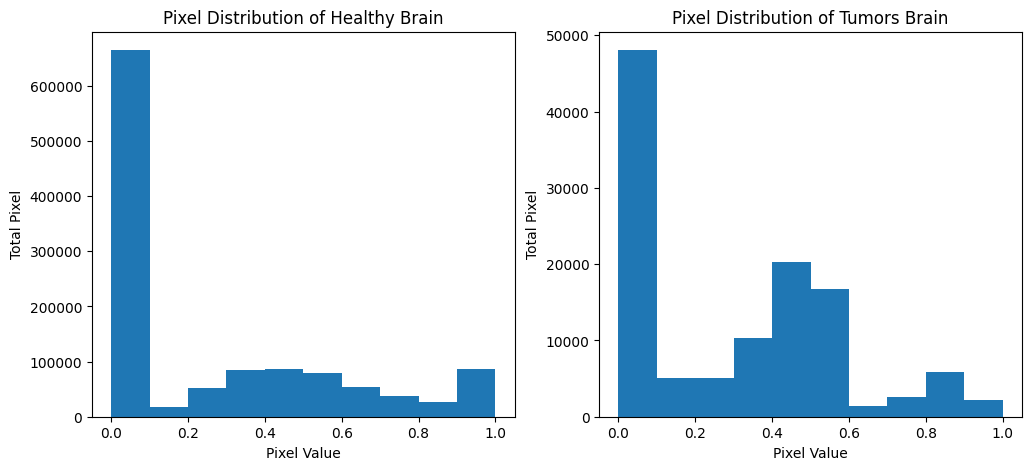

In [ ]:
yes = "Dataset/train-val-test/train/yes/y53.jpg"
no = "Dataset/train-val-test/train/no/no0.jpg"

img_no = plt.imread(no) / 255 #reads image data
img_yes = plt.imread(yes) / 255 #reads image data

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12, 5))
axis1.hist(img_no.ravel(), bins=10)
axis1.set_title("Pixel Distribution of Healthy Brain")
axis1.set_ylabel("Total Pixel")
axis1.set_xlabel("Pixel Value")


axis2.hist(img_yes.ravel(), bins=10)
axis2.set_title("Pixel Distribution of Tumors Brain")
axis2.set_ylabel("Total Pixel")
axis2.set_xlabel("Pixel Value")

## B. Data Processing

### Initialization Parameter

In [ ]:
# Inizialition Parameter
train_example =  len(os.listdir(train_yes_dir)) + len(os.listdir(train_no_dir))
val_example = len(os.listdir(validation_yes_dir)) + len(os.listdir(validation_no_dir))
test_example = len(os.listdir(testing_yes_dir)) + len(os.listdir(testing_no_dir))
img_height = img_width = 150

### Hyperparameter

In [ ]:
# Hyperparameter
EPOCH = 50
BATCH_SIZE = 16
STEPS_PER_EPOCH = int(train_example / BATCH_SIZE)
VALIDATON_STEPS = int(val_example / BATCH_SIZE)

### Data Augmentation and Data Generator

In [ ]:
# Apply data augmentation
train_datagen = ImageDataGenerator(
      rescale = 1./255, #normalization to change value from 0 - 255 to 0 -1
      # rotation_range = 30,
      fill_mode = 'nearest'
      )

validation_datagen = ImageDataGenerator(rescale=1./255) #normalization
test_datagen = ImageDataGenerator(rescale=1./255) #normalization

# Data Generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size = (img_height, img_width),  # All images will be resized to 150 x 150
        batch_size = BATCH_SIZE,
        class_mode ='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # This is the source directory for training images
        target_size = (img_height, img_width),  # All images will be resized to 150 x 150
        batch_size = BATCH_SIZE,
        class_mode ='binary')

test_generator = test_datagen.flow_from_directory(
        testing_dir,  # This is the source directory for training images
        target_size = (img_height, img_width),  # All images will be resized to 150 x 150
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

Found 2100 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## C. Model Selection

### Model 1

#### Architecture

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = inputs

# Convolutional Block 1
x = tf.keras.layers.Convolution2D(128, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(128, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Convolutional Block 2
x = tf.keras.layers.Convolution2D(64, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(64, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Convolutional Block 3
x = tf.keras.layers.Convolution2D(32, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(32, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Convolutional Block 4
x = tf.keras.layers.Convolution2D(16, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(16, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Convolutional Block 5
x = tf.keras.layers.Convolution2D(8, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(8, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Flatten Layer
x = tf.keras.layers.GlobalAvgPool2D()(x)

# Dense Layer / Fully Connected Layers
x = tf.keras.layers.Dense(128, activation = 'relu')(x)

# Regulatrization Layers
x = tf.keras.layers.Dropout(0.2)(x)

# Finaly Layers
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

# Combine all layers into one connected layers
model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 128)    512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 150, 150, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 128)    512       
 hNormalization)                                             

In [ ]:
# Compiler
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = 'binary_crossentropy',
    metrics = METRICS
)

In [ ]:
log_dir = "logs/fit/" + "Trial - 5 - Hypermodel"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# %reload_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 24188), started 20:53:15 ago. (Use '!kill 24188' to kill it.)

In [ ]:
History = model.fit(
      train_generator,
      epochs=EPOCH,
      steps_per_epoch = STEPS_PER_EPOCH,
      validation_data=validation_generator,
      validation_steps = VALIDATON_STEPS,
      callbacks= [tensorboard_callback],
      verbose=1)

history_evaluate = model.evaluate(test_generator)

Epoch 1/50
131/131 [==============================] - 52s 272ms/step - loss: 0.6522 - accuracy: 0.6262 - TP: 417.0000 - TN: 888.0000 - FP: 155.0000 - FN: 624.0000 - precision: 0.7290 - val_loss: 0.6951 - val_accuracy: 0.5051 - val_TP: 0.0000e+00 - val_TN: 299.0000 - val_FP: 0.0000e+00 - val_FN: 293.0000 - val_precision: 0.0000e+00
Epoch 2/50
131/131 [==============================] - 29s 219ms/step - loss: 0.5405 - accuracy: 0.7865 - TP: 818.0000 - TN: 821.0000 - FP: 219.0000 - FN: 226.0000 - precision: 0.7888 - val_loss: 0.6710 - val_accuracy: 0.5574 - val_TP: 169.0000 - val_TN: 161.0000 - val_FP: 137.0000 - val_FN: 125.0000 - val_precision: 0.5523
Epoch 3/50
131/131 [==============================] - 29s 218ms/step - loss: 0.4350 - accuracy: 0.8359 - TP: 879.0000 - TN: 863.0000 - FP: 180.0000 - FN: 162.0000 - precision: 0.8300 - val_loss: 0.5617 - val_accuracy: 0.7179 - val_TP: 255.0000 - val_TN: 170.0000 - val_FP: 127.0000 - val_FN: 40.0000 - val_precision: 0.6675
Epoch 4/50
131/131

In [ ]:
model.save('model/model.h5')

In [ ]:
history_evaluate = model.evaluate(test_generator)

19/19 [==============================] - 1s 66ms/step - loss: 0.1259 - accuracy: 0.9667 - TP: 147.0000 - TN: 143.0000 - FP: 7.0000 - FN: 3.0000 - precision: 0.9545


In [ ]:
history_evaluate = model.evaluate(validation_generator)

In [ ]:
print(history_evaluate)
sensitivity, specificity, precision, recall, dsc, F1_score = Custom_Metrics(history_evaluate[2],history_evaluate[3],history_evaluate[4],history_evaluate[5])
print("sensitivity :",sensitivity)
print("specificity :",specificity)
print("precision :",precision)
print("recall :",recall)
print("DSC :",dsc)
print("F1_score :",F1_score)
print("Built-in Precision :", history_evaluate[6])

[0.12593773007392883, 0.9666666388511658, 147.0, 143.0, 7.0, 3.0, 0.9545454382896423]
sensitivity : 0.98
specificity : 0.9533333333333334
precision : 0.9545454545454546
recall : 0.98
DSC : 0.9671052631578947
F1_score : 0.9671052631578947
Built-in Precision : 0.9545454382896423


#### Observe CNN Result

In [ ]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
tumor_img_files = [os.path.join(train_yes_dir, f) for f in train_yes_fnames]
healthy_img_files = [os.path.join(train_no_dir, f) for f in train_no_fnames]

img_path = random.choice(tumor_img_files + healthy_img_files)
img = load_img(img_path, target_size=(img_height, img_width))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))

    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 40. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

## D. Hyperparameter Tunning

This method will search the best hyperparamet for this case to get best model from choosen model above.

This method have 2 mechanism :
1. Manualy observe the loss and acc parameter for best lr
2. Using keras tuner for automatically search best lr, dense and epoch for model

### First Method

#### Define Callback for Hyperparameter Tuning

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-5 * 10 ** (epoch / 20))

model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = METRICS)

history = model.fit(train_generator, epochs =100 , callbacks=[lr_schedule, tensorboard_callback])


Epoch 1/100
33/33 [==============================] - 6s 142ms/step - loss: 0.0040 - accuracy: 0.9996 - TP: 1217.0000 - TN: 1202.0000 - FP: 1.0000 - FN: 0.0000e+00 - precision: 0.9992 - lr: 1.0000e-05
Epoch 2/100
33/33 [==============================] - 5s 155ms/step - loss: 0.0036 - accuracy: 1.0000 - TP: 1050.0000 - TN: 1050.0000 - FP: 0.0000e+00 - FN: 0.0000e+00 - precision: 1.0000 - lr: 1.1220e-05
Epoch 3/100
33/33 [==============================] - 5s 151ms/step - loss: 0.0023 - accuracy: 1.0000 - TP: 1050.0000 - TN: 1050.0000 - FP: 0.0000e+00 - FN: 0.0000e+00 - precision: 1.0000 - lr: 1.2589e-05
Epoch 4/100
33/33 [==============================] - 5s 164ms/step - loss: 0.0017 - accuracy: 1.0000 - TP: 1050.0000 - TN: 1050.0000 - FP: 0.0000e+00 - FN: 0.0000e+00 - precision: 1.0000 - lr: 1.4125e-05
Epoch 5/100
33/33 [==============================] - 5s 151ms/step - loss: 0.0016 - accuracy: 1.0000 - TP: 1050.0000 - TN: 1050.0000 - FP: 0.0000e+00 - FN: 0.0000e+00 - precision: 1.0000 -

#### Visualize Hyperparameter Performance

##### Accuracy

(1e-05, 1.0, 0.0, 1.0)

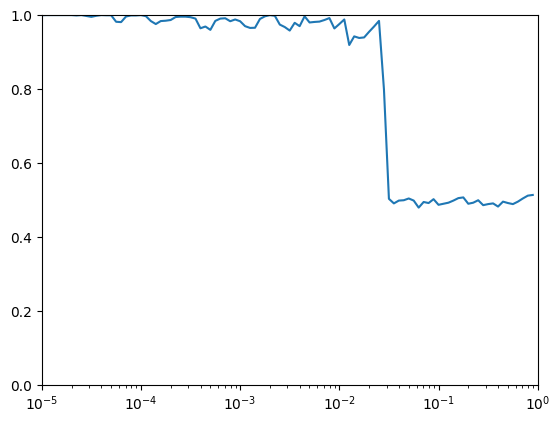

In [ ]:
plt.semilogx(history.history["lr"], history.history["accuracy"])
plt.axis([1e-5, 1, 0, 1])

##### Loss

(1e-05, 1.0, 0.0, 2.0)

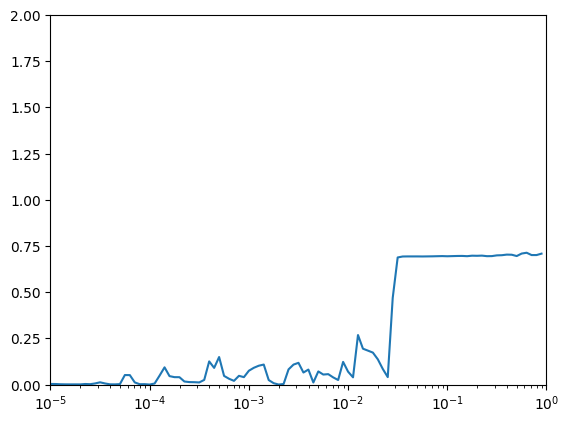

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 2])

#### Retrain Model with Best Hyperparameter

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2.2387e-05),
              loss = 'binary_crossentropy',
              metrics = METRICS)

model_retrain_with_tuning = model.fit(train_generator,
      epochs=EPOCH,
      steps_per_epoch = STEPS_PER_EPOCH,
      validation_data=validation_generator,
      validation_steps = VALIDATON_STEPS,
      callbacks= [tensorboard_callback],
      verbose=1)

### Second Method
This method wil use keras tuner for hyperparameter tuning

In [ ]:
# Hypermodel
def build_model(hp):
  inputs = tf.keras.Input(shape=(img_height, img_width, 3))
  x = inputs

  # Build Convolutional Block
  for i in range(hp.Int('conv_blocks', min_value = 3, max_value = 5)):
    filters = hp.Int('filters_' + str(i), min_value = 32, max_value = 256, step = 32)

    # Convolutional Layers
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(filters, kernel_size = (3,3), padding = 'same',)(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)

    # Pooling Layers
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D()(x)
    else :
      x = tf.keras.layers.AvgPool2D()(x)

  # Flatten Layer
  x = tf.keras.layers.GlobalAvgPool2D()(x)

  # Dense Layer / Fully Connected Layers
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', min_value = 32, max_value = 128, default = 32),
      activation = 'relu'
      )(x)

  # Regulatrization Layers
  x = tf.keras.layers.Dropout(
      hp.Float('dropout', min_value = 0, max_value = 0.5, step = 0.1, default = 0.5)
      )(x)

  # Finaly Layers
  outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

  # Combine all layers into one connected layers
  model = tf.keras.Model(inputs, outputs)

  # Compiler
  model.compile(
      optimizer = tf.keras.optimizers.Adam(
          hp.Float('learning_rate', min_value = 1e-6, max_value = 1e-3, sampling='log')
          ),
      loss = 'binary_crossentropy',
      metrics = ['accuracy']
  )
  # print(model.summary())
  return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective = 'val_accuracy',
    max_epochs = 30,
    hyperband_iterations = 2,
    directory = 'Hyperparameter Tuning',
    project_name = 'Trial - 0 - Model Experimental'
)

INFO:tensorflow:Reloading Tuner from Hyperparameter Tuning\Trial - 0 - Model Experimental\tuner0.json


In [ ]:
tuner.search(
    train_generator,
    validation_data = validation_generator,
    epochs = 30,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 1)]
)

Trial 174 Complete [00h 00m 45s]
val_accuracy: 0.5683333277702332

Best val_accuracy So Far: 0.9750000238418579
Total elapsed time: 05h 35m 47s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = inputs

# Convolutional Block 1
x = tf.keras.layers.Convolution2D(64, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(64, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Convolutional Block 2
x = tf.keras.layers.Convolution2D(160, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(160, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Convolutional Block 3
x = tf.keras.layers.Convolution2D(64, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(64, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Convolutional Block 4
x = tf.keras.layers.Convolution2D(32, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(32, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Convolutional Block 5
x = tf.keras.layers.Convolution2D(224, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Convolution2D(224, kernel_size = (3,3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool2D()(x)

# Flatten Layer
x = tf.keras.layers.GlobalAvgPool2D()(x)

# Dense Layer / Fully Connected Layers
x = tf.keras.layers.Dense(72, activation = 'relu')(x)

# Regulatrization Layers
x = tf.keras.layers.Dropout(0.1)(x)

# Finaly Layers
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

# Combine all layers into one connected layers
hypermodel = tf.keras.Model(inputs, outputs)

# Compiler
hypermodel.compile(
    optimizer = tf.keras.optimizers.Adam(0.00050178),
    loss = 'binary_crossentropy',
    metrics = METRICS
)
print(hypermodel.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 150, 150, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 batch_normalization_11 (Bat  (None, 150, 150, 64)     256       
 chNormalization)                                          

In [ ]:
History_hyper = hypermodel.fit(
    train_generator,
    epochs=EPOCH,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps = VALIDATON_STEPS,
    callbacks= [tensorboard_callback],
    verbose=1)

Epoch 1/50
131/131 [==============================] - 29s 182ms/step - loss: 0.5302 - accuracy: 0.7714 - TP: 941.0000 - TN: 898.0000 - FP: 293.0000 - FN: 252.0000 - precision: 0.7626 - val_loss: 0.7054 - val_accuracy: 0.4848 - val_TP: 286.0000 - val_TN: 1.0000 - val_FP: 296.0000 - val_FN: 9.0000 - val_precision: 0.4914
Epoch 2/50
131/131 [==============================] - 21s 162ms/step - loss: 0.3571 - accuracy: 0.8498 - TP: 884.0000 - TN: 887.0000 - FP: 158.0000 - FN: 155.0000 - precision: 0.8484 - val_loss: 0.5911 - val_accuracy: 0.6537 - val_TP: 277.0000 - val_TN: 110.0000 - val_FP: 189.0000 - val_FN: 16.0000 - val_precision: 0.5944
Epoch 3/50
131/131 [==============================] - 21s 164ms/step - loss: 0.2206 - accuracy: 0.9203 - TP: 959.0000 - TN: 959.0000 - FP: 82.0000 - FN: 84.0000 - precision: 0.9212 - val_loss: 0.4779 - val_accuracy: 0.8024 - val_TP: 280.0000 - val_TN: 195.0000 - val_FP: 102.0000 - val_FN: 15.0000 - val_precision: 0.7330
Epoch 4/50
131/131 [=============

In [ ]:
hyper_evaluate = hypermodel.evaluate(test_generator)

19/19 [==============================] - 2s 123ms/step - loss: 0.1285 - accuracy: 0.9833 - TP: 148.0000 - TN: 147.0000 - FP: 3.0000 - FN: 2.0000 - precision: 0.9801


In [ ]:
sensitivity, specificity, precision, recall, dsc, F1_score = Custom_Metrics(hyper_evaluate[2],hyper_evaluate[3],hyper_evaluate[4],hyper_evaluate[5])
print("sensitivity :",sensitivity)
print("specificity :",specificity)
print("precision :",precision)
print("recall :",recall)
print("DSC :",dsc)
print("F1_score :",F1_score)
print("Built-in Precision :", hyper_evaluate[6])

sensitivity : 0.9866666666666667
specificity : 0.98
precision : 0.9801324503311258
recall : 0.9866666666666667
DSC : 0.9833887043189369
F1_score : 0.983388704318937
Built-in Precision : 0.9801324605941772


In [ ]:
hypermodel.save('Hypermodel.h5')

In [ ]:
val_acc_per_epoch = History_hyper.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 24


In [ ]:
eval_result = hypermodel.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

19/19 [==============================] - 1s 50ms/step - loss: 0.1285 - accuracy: 0.9833 - TP: 148.0000 - TN: 147.0000 - FP: 3.0000 - FN: 2.0000 - precision: 0.9801
[test loss, test accuracy]: [0.12852191925048828, 0.9833333492279053, 148.0, 147.0, 3.0, 2.0, 0.9801324605941772]


#### Observer CNN Result

In [ ]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in hypermodel.layers]
visualization_model = tf.keras.models.Model(inputs = hypermodel.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
tumor_img_files = [os.path.join(train_yes_dir, f) for f in train_yes_fnames]
healthy_img_files = [os.path.join(train_no_dir, f) for f in train_no_fnames]

img_path = random.choice(tumor_img_files + healthy_img_files)
img = load_img(img_path, target_size=(img_height, img_width))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))

    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 40. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

## E. Evaluation

the evaluation step will check loss, acc, and confusion metrics also DSC metric from model and hypermodel.

#### Initial Model

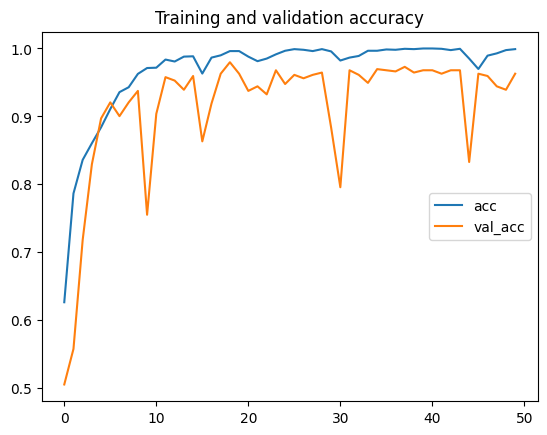

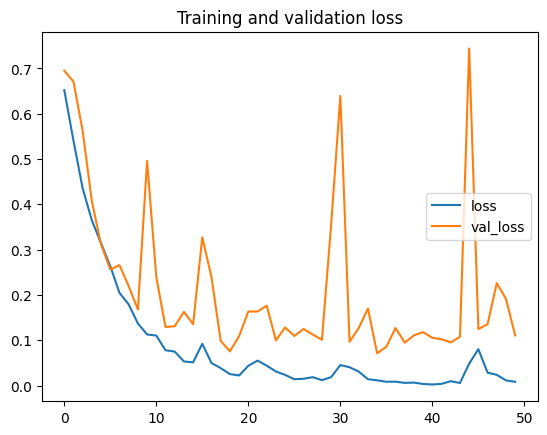

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = History.history[     'accuracy' ]
val_acc  = History.history[ 'val_accuracy' ]
loss     = History.history[    'loss' ]
val_loss = History.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label ='acc' )
plt.plot  ( epochs, val_acc, label ='val_acc' )
plt.title ('Training and validation accuracy')
plt.legend(loc ="center right")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label ='loss')
plt.plot  ( epochs, val_loss, label ='val_loss')
plt.title ('Training and validation loss'   )
plt.legend(loc ="center right")

In [ ]:
model = tf.keras.models.load_model('All-Model/model/model.h5')

In [ ]:
history_evaluate = model.evaluate(test_generator)

19/19 [==============================] - 16s 343ms/step - loss: 0.1259 - accuracy: 0.9667 - TP: 147.0000 - TN: 143.0000 - FP: 7.0000 - FN: 3.0000 - precision: 0.9545


In [ ]:
print(history_evaluate)
sensitivity, specificity, precision, recall, dsc, F1_score = Custom_Metrics(history_evaluate[2],history_evaluate[3],history_evaluate[4],history_evaluate[5])
print("sensitivity :",sensitivity)
print("specificity :",specificity)
print("precision :",precision)
print("recall :",recall)
print("DSC :",dsc)
print("F1_score :",F1_score)
print("Built-in Precision :", history_evaluate[6])

[0.12593768537044525, 0.9666666388511658, 147.0, 143.0, 7.0, 3.0, 0.9545454382896423]
sensitivity : 0.98
specificity : 0.9533333333333334
precision : 0.9545454545454546
recall : 0.98
DSC : 0.9671052631578947
F1_score : 0.9671052631578947
Built-in Precision : 0.9545454382896423


[Text(0, 0, '98'),
 Text(0, 0, '95'),
 Text(0, 0, '95'),
 Text(0, 0, '97'),
 Text(0, 0, '97')]

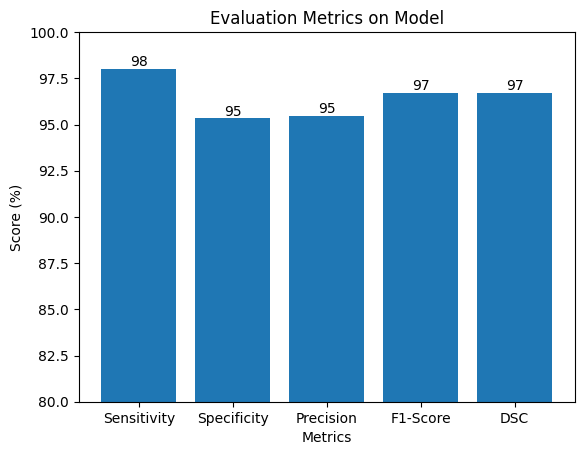

In [ ]:
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1-Score', "DSC"]
values = [sensitivity * 100, specificity * 100, precision * 100, F1_score * 100, dsc * 100]

fig, ax = plt.subplots()
bar_container = ax.bar(metrics, values)
ax.set(ylabel='Score (%)',xlabel = "Metrics", title='Evaluation Metrics on Model', ylim=(80, 100))
ax.bar_label(bar_container, fmt='{:,.0f}')

### Hyper Model

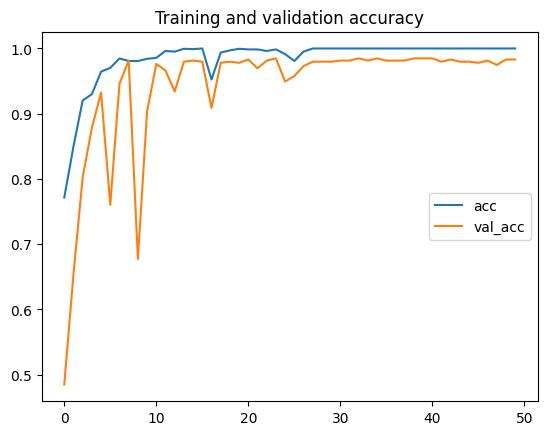

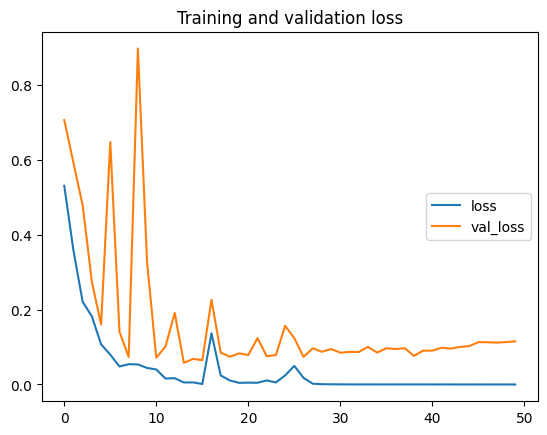

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = History_hyper.history[     'accuracy' ]
val_acc  = History_hyper.history[ 'val_accuracy' ]
loss     = History_hyper.history[    'loss' ]
val_loss = History_hyper.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label ='acc' )
plt.plot  ( epochs, val_acc, label ='val_acc' )
plt.title ('Training and validation accuracy')
plt.legend(loc ="center right")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label ='loss')
plt.plot  ( epochs, val_loss, label ='val_loss')
plt.title ('Training and validation loss'   )
plt.legend(loc ="center right")

In [ ]:
hypermodel = tf.keras.models.load_model('All-Model/Hyper-Model/Hypermodel.h5')

In [ ]:
history_hyper_evaluate = hypermodel.evaluate(test_generator)

19/19 [==============================] - 2s 55ms/step - loss: 0.0583 - accuracy: 0.9867 - TP: 147.0000 - TN: 149.0000 - FP: 1.0000 - FN: 3.0000 - precision: 0.9932


In [ ]:
print(history_hyper_evaluate)
hyper_sensitivity, hyper_specificity, hyper_precision, hyper_recall, hyper_dsc, hyper_F1_score = Custom_Metrics(history_hyper_evaluate[2],history_hyper_evaluate[3],history_hyper_evaluate[4],history_hyper_evaluate[5])
print("sensitivity :",hyper_sensitivity)
print("specificity :",hyper_specificity)
print("precision :",hyper_precision)
print("recall :",hyper_recall)
print("DSC :",hyper_dsc)
print("F1_score :",hyper_F1_score)
print("Built-in Precision :", history_hyper_evaluate[6])

[0.05828682705760002, 0.9866666793823242, 147.0, 149.0, 1.0, 3.0, 0.9932432174682617]
sensitivity : 0.98
specificity : 0.9933333333333333
precision : 0.9932432432432432
recall : 0.98
DSC : 0.9865771812080537
F1_score : 0.9865771812080537
Built-in Precision : 0.9932432174682617


[Text(0, 0, '98'),
 Text(0, 0, '99'),
 Text(0, 0, '99'),
 Text(0, 0, '99'),
 Text(0, 0, '99')]

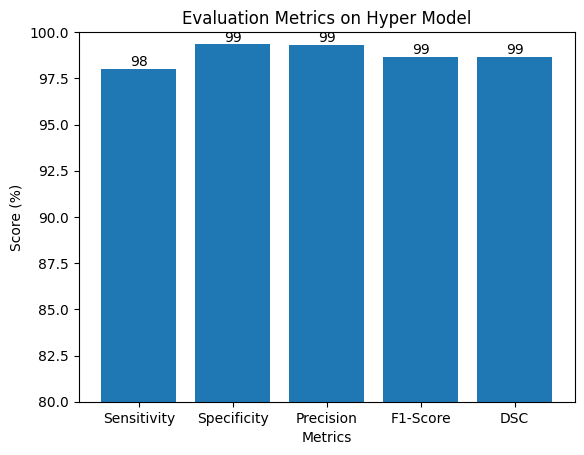

In [ ]:
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1-Score', "DSC"]
values = [hyper_sensitivity * 100, hyper_specificity * 100, hyper_precision * 100, hyper_F1_score * 100, hyper_dsc * 100]

fig, ax = plt.subplots()
bar_container = ax.bar(metrics, values)
ax.set(ylabel='Score (%)',xlabel = "Metrics", title='Evaluation Metrics on Hyper Model', ylim=(80, 100))
ax.bar_label(bar_container, fmt='{:,.0f}')

## F. Testing / Deployment

testing model with unseen images that upload from colab and give the final result from 4 class (Healthy, Rust, Phoma, or miner)

1/1 [==============================] - 0s 25ms/step


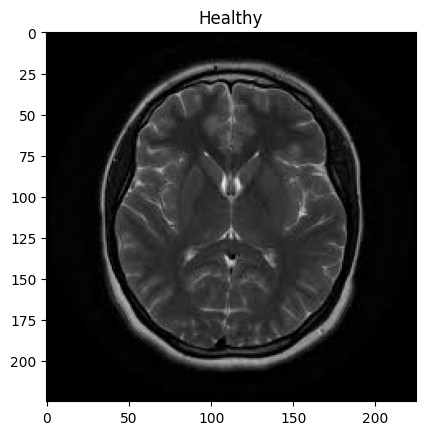

In [ ]:
# predicting images
path = "Dataset/pred/pred37.jpg"
img = load_img(path, target_size=(img_height, img_width))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
prediction = hypermodel.predict(images)
if prediction == 0:
  # Show Image
  image = mpimg.imread(path)
  plt.title("Healthy")
  plt.imshow(image)

elif prediction == 1:
  # Show Image
  image = mpimg.imread(path)
  plt.title("Tumor")
  plt.imshow(image)

1/1 [==============================] - 0s 24ms/step


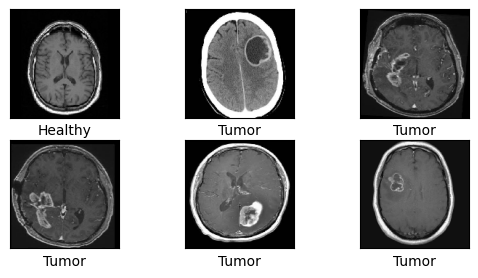

In [ ]:
# plt.figure(figsize=(3,3))
basedir = "Dataset/pred/"
file_mri = [x for x in os.listdir(basedir)]
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img = load_img(basedir + file_mri[i], target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    prediction = hypermodel.predict(images)
    if prediction == 0:
      result = "Healthy"

    elif prediction == 1:
      result = "Tumor"

    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(result)
plt.show()
# print(file_mri)

##Saving Model

model will save into HDF5 --> JSON Converter file to predict it in javascripts using TF.js library from tensorflow for Browser Based model

In [ ]:
model.save("model.h5")

In [ ]:
hypermodel.save("hypermodel.h5")

##Load Model (optional)

Load the last saved model to test prediction before it deploy on backend Web

In [ ]:
model = tf.keras.models.load_model("model.h5")
hypermodel = tf.keras.models.load_model("hypermodel.h5")

## Compare Model

Metrics from proposed model will be compared to other research achievement

Accuracy

[Text(0, 0, '99.3'), Text(0, 0, '98.6')]

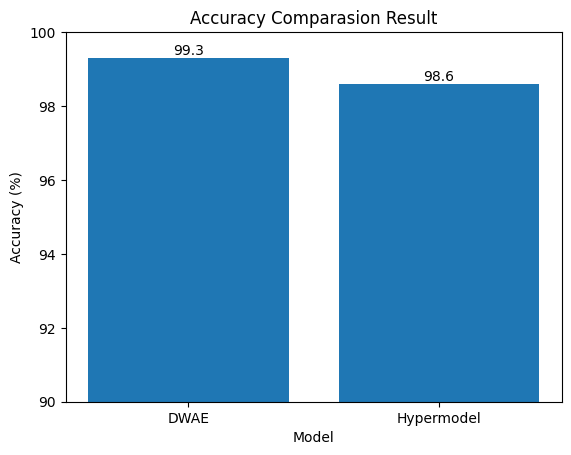

In [ ]:
acc_penelititan_terkait = 99.3
acc_hypermodel = 98.6

#data
model = ['DWAE', 'Hypermodel']
values = [acc_penelititan_terkait, acc_hypermodel]

fig, ax = plt.subplots()
bar_container = ax.bar(model, values)
ax.set(ylabel='Accuracy (%)',xlabel = "Model", title='Accuracy Comparasion Result', ylim=(90, 100))
ax.bar_label(bar_container, fmt='{:,.1f}')

Sensitivity

[Text(0, 0, '95.6'), Text(0, 0, '98.0')]

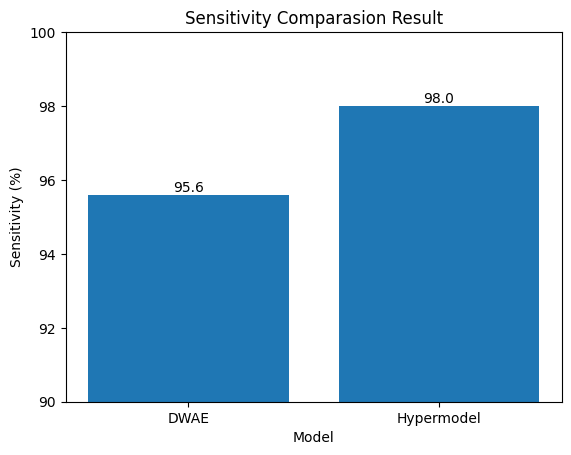

In [ ]:
sen_penelititan_terkait = 95.6
sen_hypermodel = 98.0

#data
model = ['DWAE', 'Hypermodel']
values = [sen_penelititan_terkait, sen_hypermodel]

fig, ax = plt.subplots()
bar_container = ax.bar(model, values)
ax.set(ylabel='Sensitivity (%)',xlabel = "Model", title='Sensitivity Comparasion Result', ylim=(90, 100))
ax.bar_label(bar_container, fmt='{:,.1f}')

Specificity

[Text(0, 0, '96.9'), Text(0, 0, '99.3')]

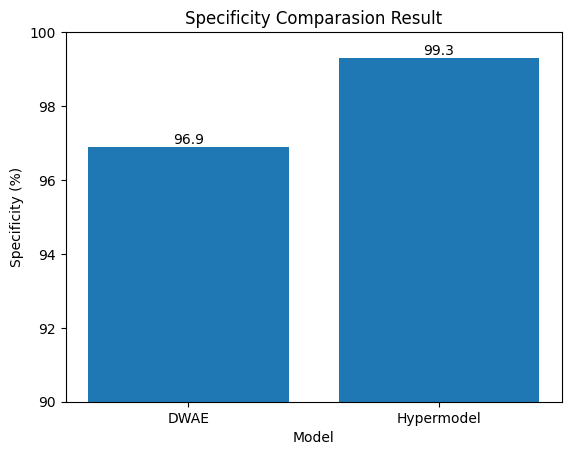

In [ ]:
spec_penelititan_terkait = 96.9
spec_hypermodel = 99.3

#data
model = ['DWAE', 'Hypermodel']
values = [spec_penelititan_terkait, spec_hypermodel]

fig, ax = plt.subplots()
bar_container = ax.bar(model, values)
ax.set(ylabel='Specificity (%)',xlabel = "Model", title='Specificity Comparasion Result', ylim=(90, 100))
ax.bar_label(bar_container, fmt='{:,.1f}')

Precision

[Text(0, 0, '97.4'), Text(0, 0, '99.3')]

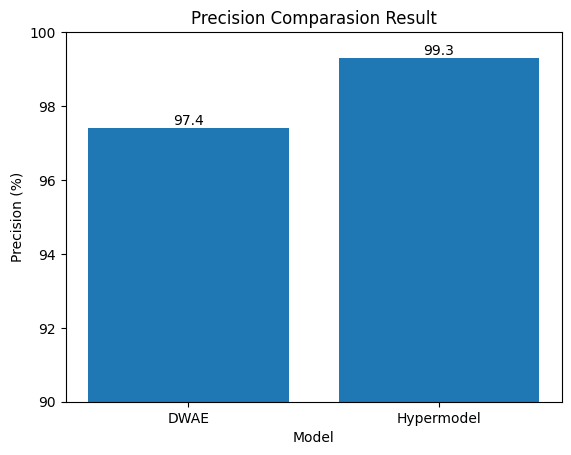

In [ ]:
pre_penelititan_terkait = 97.4
pre_hypermodel = 99.3

#data
model = ['DWAE', 'Hypermodel']
values = [pre_penelititan_terkait, pre_hypermodel]

fig, ax = plt.subplots()
bar_container = ax.bar(model, values)
ax.set(ylabel='Precision (%)',xlabel = "Model", title='Precision Comparasion Result', ylim=(90, 100))
ax.bar_label(bar_container, fmt='{:,.1f}')

F1-Score

In [ ]:
acc_penelititan_terkait = 99.3
acc_hypermodel = 98.6

#data
model = ['DWAE', 'Hypermodel']
values = [acc_penelititan_terkait, acc_hypermodel]

fig, ax = plt.subplots()
bar_container = ax.bar(model, values)
ax.set(ylabel='Accuracy (%)',xlabel = "Model", title='Accuracy Comparasion Result', ylim=(90, 100))
ax.bar_label(bar_container, fmt='{:,.1f}')

DSC

[Text(0, 0, '96.5'), Text(0, 0, '98.6')]

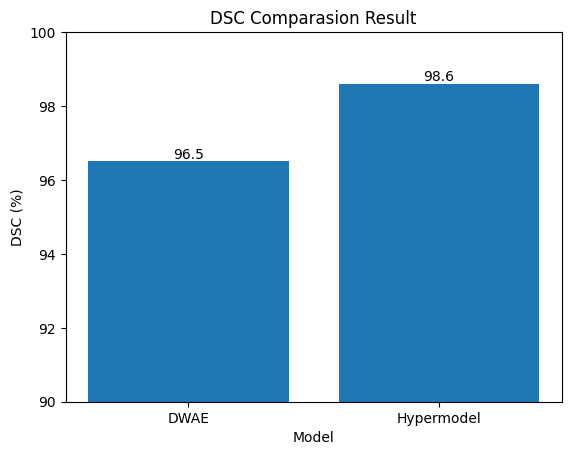

In [ ]:
dsc_penelititan_terkait = 96.5
dsc_hypermodel = 98.6

#data
model = ['DWAE', 'Hypermodel']
values = [dsc_penelititan_terkait, dsc_hypermodel]

fig, ax = plt.subplots()
bar_container = ax.bar(model, values)
ax.set(ylabel='DSC (%)',xlabel = "Model", title='DSC Comparasion Result', ylim=(90, 100))
ax.bar_label(bar_container, fmt='{:,.1f}')